# Introduction
Clustering tackles the problem of grouping data into exclusive sets, or clusters, such that points in a cluster are more similar to each other than points in other clusters.

It is an unsupervised learning technique, meaning that there are no predefined classes or examples to learn from.

# Partitional Clustering
Partitional clustering attempts to decompose the data into a predefined number of clusters by iteratively optimizing some objective function.


## K-Means Clustering
K-means is a clustering technique. It aims to divide the data into $k$ exclusive sets, each defined by its mean (centroid). This $k$ must be set by us, either by guessing or by conducting analysis to determine an optimal $k$.



### Algorithm
1. Choose $k$ points at random from the data. These points will be the initial centroids of the clusters.
2. Assign every point in the data to be of the cluster of whose centroid it is closest to.
3. Compute the mean of each cluster. This will be the cluster's new centroid.
4. Repeat steps 2 and 3 until cluster arrangements stop changing or a maximum number of iterations is reached.



### Distance Metric
One might intuitively use the Euclidean distance, given by:$$d(\mathbf{p},\mathbf{q})=\sqrt{\sum_{i=1}^n(p_i-q_i)^2}$$where:
- $\mathbf{p}, \mathbf{q}$ are two points in Euclidean $n$-space
- $p_i,q_i$ are vectors along the $i$-th dimension.

Equivalently, we can use a distance of $d(\mathbf{p},\mathbf{q})^2$ because  $x^2$  is monotonic (i.e. preserves order) and the square root is redundant. Thus, we have:$$d(\mathbf{p},\mathbf{q})^2=\sum_{i=1}^n(p_i-q_i)^2$$

Not only does this compute the Euclidean-squared distance, it also computes the variance between two points! ([Proof](https://stats.stackexchange.com/questions/378991/a-proof-of-within-cluster-sum-of-squares))

### Objective
To quantify how good a cluster is, we can take the sum of the distances of all points to their grouped cluster. We define our within-cluster sum of squares for a cluster $k$ as,
$$\text{SS}_{W_k}=\sum_{x\in C_k}d(\mathbf{x},\bar{C_k})^2$$
If we take the mean of the within-cluster sum of squares, we get the within-cluster variation:
$$\text{WCV}(C_k)=\frac{1}{|C_k|}SS_{W_k}$$
where
- $C_k$ is the $k$th cluster.
- $|C_k|$ is the number of points in a cluster
- $\bar{C_k}$ is the mean of the cluster.

To quantify how good the entire model is, we can take the sum of all within-cluster variations of each cluster. Hence, our problem is
$$\underset{C_1,\ldots,C_k}{\min}\sum_{k=1}^K\frac{1}{|C_k|}\sum_{\mathbf{x}\in C_k}\sum_{i=1}^n(x_i-\bar{C_k})^2$$

### Assumptions X
- Clusters are convex.

### Implementation
Let's apply k-means to the iris dataset.

#### Data

In [1]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris(as_frame = True)
iris = pd.concat([iris.data, iris.target], axis = 1)

Taking a look at our data:

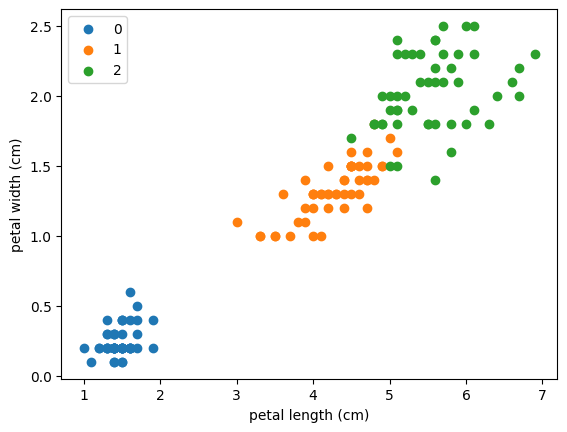

In [2]:
import matplotlib.pyplot as plt

groups = iris.groupby('target')

for name, group in groups:
    plt.scatter(group['petal length (cm)'], group['petal width (cm)'], label = name)

plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

plt.legend()
plt.show()

Let's try k-means with $k=3$ and see what groups we get.

In [3]:
import numpy as np
from sklearn.cluster import KMeans

k_means_3 = KMeans(n_clusters = 3, n_init = 'auto')

X = np.array(iris[['petal length (cm)', 'petal width (cm)']])

k_means_3.fit(X)

KMeans(n_clusters=3)

In [4]:
import pandas as pd

iris['class_predictions'] = k_means_3.labels_
pd.crosstab(iris['target'],
            iris['class_predictions'],
            rownames = ['target'],
            colnames = ['class_predictions'])

class_predictions,0,1,2
target,,,
0,50,0,0
1,0,48,2
2,0,6,44


We see that group 0 mostly correlates to virginica, 1 to setosa, and 2 to versicolor.

In [5]:
c_map = {
    0: 'virginica',
    1: 'setosa',
    2: 'versicolor'
}

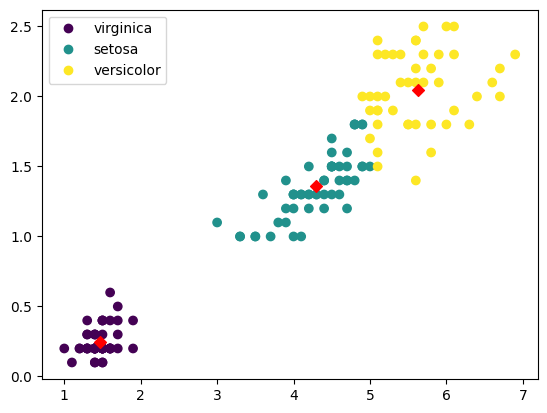

In [6]:
scatter = plt.scatter(*X.T, c = k_means_3.labels_)
plt.scatter(*k_means_3.cluster_centers_.T, c = 'r', marker = 'D')

plt.legend(handles = scatter.legend_elements()[0], labels = list(c_map.values()))

plt.show()

### Choosing $k$
To decide on an ideal $k$, we can test clustering models of varying $k$ and compare their error. Let's test $k=1,\ldots,10$ and use our above sum of within cluster variations as our error.


First, apply k-means for $k=1,\ldots,10$.

In [7]:
models = []
for k in range(1, 11):
    model = KMeans(n_clusters = k, n_init = 'auto')
    model.fit(X) # X defined earlier
    models.append(model)

Define within-cluster sum of squares.
$$\text{SS}_{W_k}=\sum_{x\in C_k}(x-\bar{C_k})^2$$

In [8]:
def within_ss_k(x):
    # compute SS_W_k
    return np.sum(np.square(x - np.mean(x, 0)))

Define the sum of $\text{SS}_{W_k}$.
$$\text{SS}_W=\sum_{k=1}^K\text{SS}_{W_k}$$

In [9]:
import pandas as pd

def within_ss(X, labels):
    index = pd.Index(labels, name = 'label')
    df = pd.DataFrame(X, index = index)

    sum_ = 0
    for _, group in df.groupby('label'):
        sum_ += within_ss_k(group.values)

    return sum_

Let's calculate the within-cluster sum of squares for our models.

In [10]:
model_errors = [within_ss(X, model.labels_) for model in models]

Then plot our results.

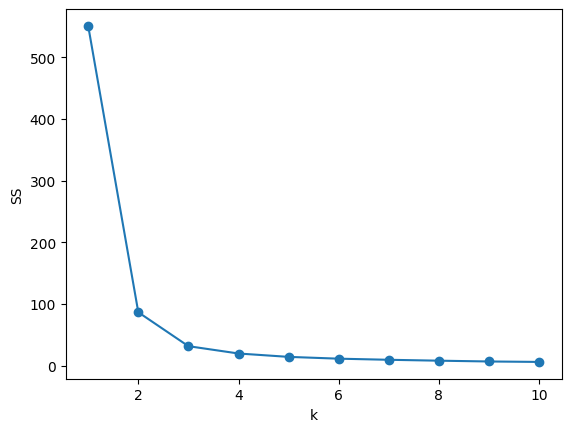

In [11]:
plt.plot(range(1, len(model_errors) + 1), model_errors, marker = 'o')
plt.xlabel('k')
plt.ylabel('SS')

plt.show()

We can see that there is a significant decrease in SS from 1 cluster to 2, then a smaller one from 2 to 3 clusters. This simple heuristic is commonly known as the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), where the "elbow" of the curve is chosen as the number of clusters to use.

The technique is subjective and unreliable but we can use it to naively guess that 3 clusters is probably optimal.

## K-Medoids
Instead of using the mean as centers (centroids), we can use the medians (medoids).

### Demo

This technique is included by `scikit-learn-extra` which is not installed in Colab by default. We can install as follows.

In [21]:
!pip install scikit-learn-extra tslearn

Let's take a look at k-medoids for $k=2,3$.

In [13]:
from sklearn_extra.cluster import KMedoids

models = []
for k in range(2, 4):
    model = KMedoids(n_clusters = k, init = 'k-medoids++')
    model.fit(X)
    models.append(model)

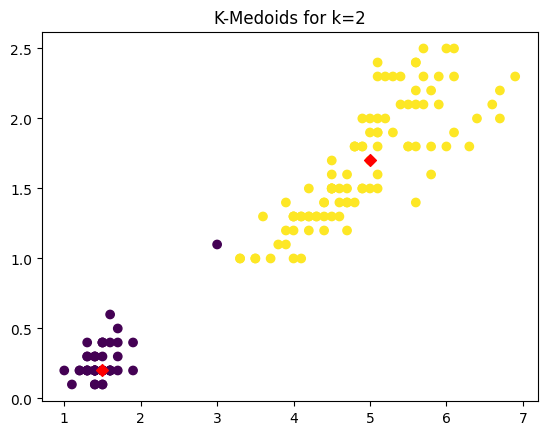

In [14]:
scatter = plt.scatter(*X.T, c = models[0].labels_)
plt.scatter(*models[0].cluster_centers_.T, c = 'r', marker = 'D')

plt.title("K-Medoids for k=2")

plt.show()

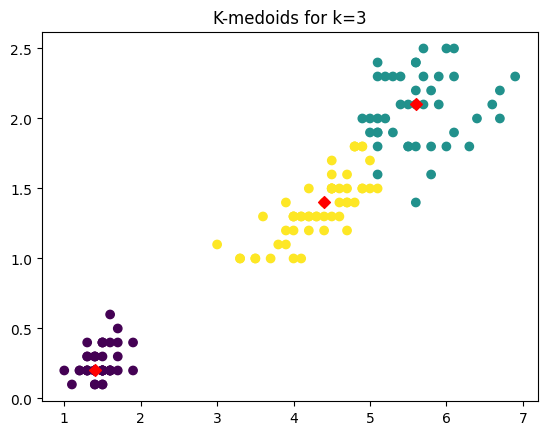

In [15]:
scatter = plt.scatter(*X.T, c = models[1].labels_)
plt.scatter(*models[1].cluster_centers_.T, c = 'r', marker = 'D')

plt.title("K-medoids for k=3")

plt.show()

And let's take a look at the elbow plot for $k=1,\ldots,10$.

In [16]:
models = []
for k in range(1, 11):
    model = KMedoids(n_clusters = k, init = 'k-medoids++')
    model.fit(X) # X defined earlier
    models.append(model)

model_errors = [within_ss(X, model.labels_) for model in models]

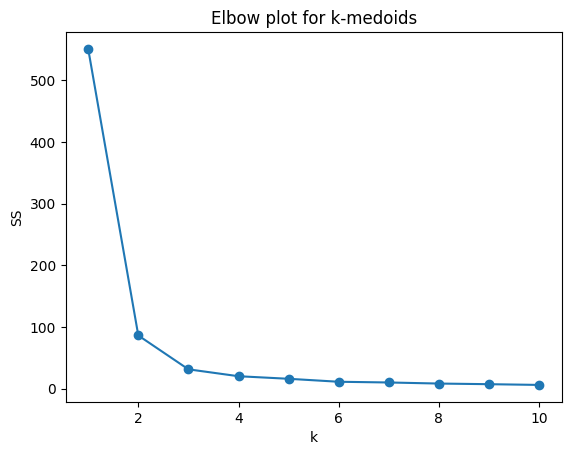

In [17]:
plt.plot(range(1, len(model_errors) + 1), model_errors, marker = 'o')

plt.title("Elbow plot for k-medoids")

plt.xlabel('k')
plt.ylabel('SS')

plt.show()

## Kernel K-Means

In [24]:
from tslearn.clustering import KernelKMeans 
models = []
for k in range(2, 4):
    model = KernelKMeans(n_clusters = k)
    model.fit(X)
    models.append(model)

/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 150 1-dimensional timeseries
  warnings.warn(
/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 150 1-dimensional timeseries
  warnings.warn(


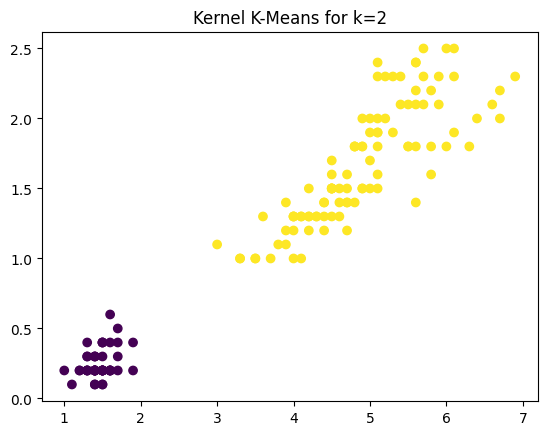

In [28]:
scatter = plt.scatter(*X.T, c = models[0].labels_)
plt.title("Kernel K-Means for k=2")
plt.show()

# Hierarchical Clustering
Hierarchical clustering sequentially splits large clusters (divisive algorithms) or merges smaller clusters (agglomerative algorithms), resulting in a tree of clusters, called a dendogram. After the procedure, we cut the dendogram at a level which determines the clusters.

## Agglomerative Clustering
In agglomerative clustering, clusters are successively merged together with the process starting with each point in its own cluster.


### Linkage Criteria
The linkage criteria determines the metric used for the merge strategy:
- **Ward** minimizes the sum of squared differences within all clusters, similar to the k-means objective function.
  - Gives most regular sizes.
- **Maximum** or **complete** linkage minimizes the maximum distance between observations of pairs of clusters.
- **Average** linkage minimizes the average of the distances between all observations of pairs of clusters.
  - Alternative to Ward when non Euclidean metrics used.
- **Single** linkage minimizes the distance between the closest observations of pairs of clusters.
  - Often leads to uneven cluster sizes.
  - Not robust on noisy data.
  - Can be cheaply computed.
  - Can perform well on non-globular data.

Here's how the different criteria behave:
<div>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png" width="500"/>
</div>

[[5]](#5)

### Demo
Let's try clustering our data using agglomerative clustering with the Ward strategy.

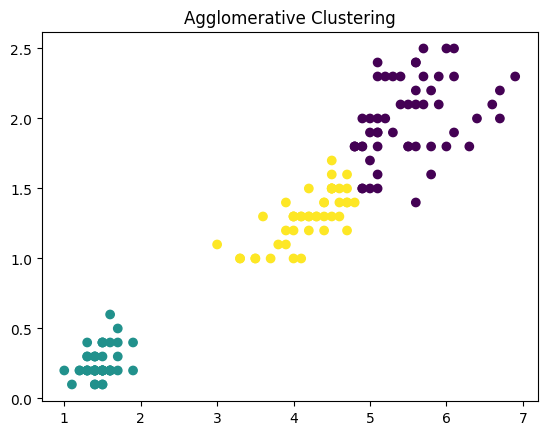

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 3)
model.fit(X)

scatter = plt.scatter(*X.T, c = model.labels_)
plt.title("Agglomerative Clustering")

plt.show()

We can also plot the dendrogram.

[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

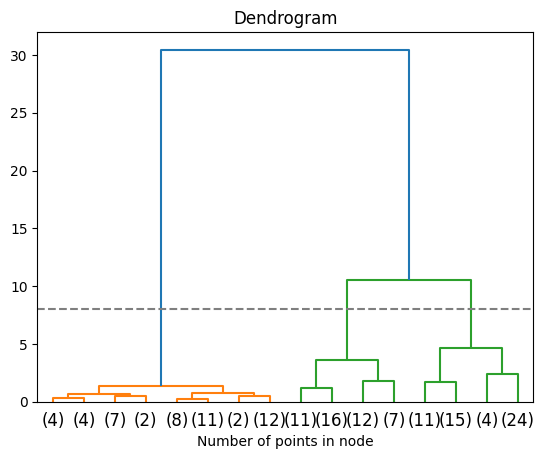

In [ ]:
from scipy.cluster.hierarchy import dendrogram

# compute the full tree
model = AgglomerativeClustering(distance_threshold = 0, n_clusters = None)
model.fit(X)

# count # of samples under each node
counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# create the linkage matrix
linkage_matrix = np.column_stack(
    [model.children_, model.distances_, counts]
).astype(float)

# plot
plt.title("Dendrogram")
dendrogram(linkage_matrix, truncate_mode = 'level', p = 3)
plt.xlabel('Number of points in node')

# add line to show where clusters are being taken
plt.axhline(y = 8, color = 'tab:gray', linestyle = 'dashed')

plt.show()

Note that, above, we are taking our clusters where the line is drawn, where it intersects with three clusters.

### Other Linkage Strategies
If you would like to see single, complete, and average linkage strategies in action, see *(Dis)similarity between groups* in [[3]](#3).

## Divisive Clustering
In divisive clustering, clusters are successively divided with the process starting with all points in a single cluster.


### Bisecting K-Means
Bisecting k-means is an iterative variant of k-means which uses divisive hierarchical clustering. Instead of creating all clusters at once, clusters are repeatedly split into two new clusters until the target number of clusters is reached.


#### Strategy
Either the current cluster with the most points or the current cluster with the greatest sum of squareed errors is chosen as the next cluster to be split.

Picking the largest cluster likely produces clusters of similar sizes.

#### Efficiency
Often, picking the largest cluster produces results as accurate as picking by inertia while being faster.

Bisecting k-means is more efficient than k-means when $k$ is large because it only works on the subset of data at each bisection while k-means works on the entire dataset.

Bisecting k-means is more efficient than agglomerative clustering if $k$ is small comapred to $n$ (number of data points).

[[5]](#5)

#### Demo

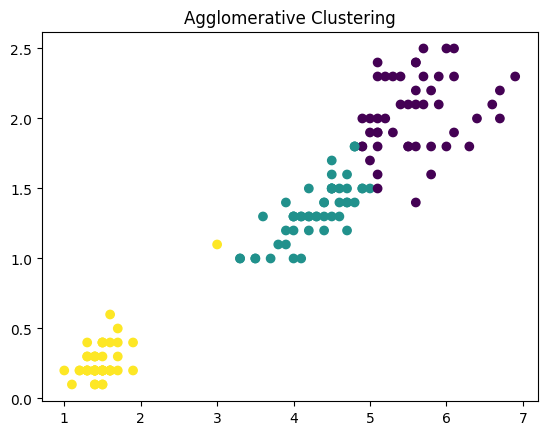

In [ ]:
from sklearn.cluster import BisectingKMeans

model = BisectingKMeans(n_clusters = 3, init = 'k-means++')
model.fit(X)

scatter = plt.scatter(*X.T, c = model.labels_)
plt.title("Agglomerative Clustering")

plt.show()

# Density-Based Clustering
Density-based algorithms regard clusters as high density regions separated by low density regions.

[[4]](#4)
[[5]](#5)

## DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering technique. The central component of DBSCAN is the idea of core samples, samples in high density areas. Thus, clusters are made up of core samples, each close to each other, and non-core samples, which are close to a core sample. Core samples are samples for which a minimum number of other samples exist within a given radius. Samples that are not within this given radius of any core samples are considered as outliers.

DBSCAN can handle noise and discover clusters of arbitrary shape.

[[4]](#4)

DBSCAN in `scikit-learn`has two central parameters: `eps` and `min_samples`. The minimum number of other samples is defined by `min_samples` and the given radius is `eps`.

### Demo

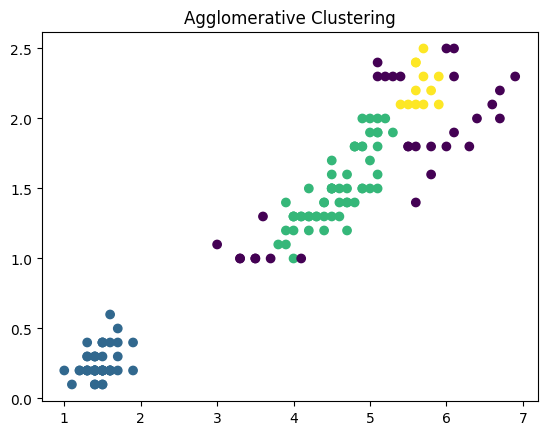

In [ ]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps = 0.2, min_samples = 5)
model.fit(X)

scatter = plt.scatter(*X.T, c = model.labels_)
plt.title("Agglomerative Clustering")

plt.show()

We see that 3 clusters form (points in blue, green, and yellow). Note that noisy samples are shown in purple.

# References
<a id="1">[1]</a>
S. Madhavan. (2015). Mastering Python for Data Science. Available: https://github.com/AmandaZou/Data-Science-books-/blob/master/Mastering%20Python%20for%20Data%20Science.pdf

<a id="2">[2]</a>
A. Boschetti, L. Massaron. (2015). Python Data Science Essentials. Available: https://aaronyeo.org/books_/Data_Science/Python/Python%20Data%20Science%20Essentials.pdf

<a id="3">[3]</a>
T. Tvedebrink. (2023). Clustering. Available: https://asta.math.aau.dk/course/dasur/2018-2/?file=files/day-4-clustering.html

<a id="4">[4]</a>
M. Halkidi, Y. Batistakis, M. Vazirgiannis. (2001.) On Clustering Validation Techniques. Available: https://web.itu.edu.tr/sgunduz/courses/verimaden/paper/validity_survey.pdf

<a id="5">[5]</a>
F. Pedregosa *et al*. (2011). Scikit-learn: Clustering. Available: https://scikit-learn.org/stable/modules/clustering.html